# **Dataset Preparation**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import json
import pickle

In [2]:
RESULTS_ROOT = "../../02_data/01_simulation_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']

In [ ]:
VEH_LIST_PATH = "../../02_data/veh_list.json"
ADV_VEH_LIST_PATH = "../../02_data/adversarial_vehicle_list.json"
PARKING_MAP_PATH = "../../02_data/parking_map.json"
TEST_DATA_PATH = "../../02_data/02_test_data"
EDGE_MAP_PATH = "../../02_data/edge_maps.json"
MOV_PROB_PATH = "../../02_data/movement_prob.csv"
SOURCE_PROB_PATH = "../../02_data/source_probs.json"
BACKWARD_PROB_PATH = "../../02_data/backward_probs.csv"
FORWARD_PROB_PATH = "../../02_data/forward_probs.json"
BACKWARD_PROB_PER_STEP_PATH = "../../02_data/backward_probs_per_steps.pickle"
ONE_HOT_ENCODING_PATH = "../../02_data/one_hot_encoding_dict.json"
FL_TEST_PATH = "../../02_data/02_test_data/fl_test_data.pickle"

In [3]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

## Vehicle data

In [4]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])

In [5]:
p_data["veh_id"] = p_data["veh_id"].apply(combine_commuters)

In [7]:
len(p_data["veh_id"].unique())

4644

### FL train

In [7]:
vehicles = np.random.choice(p_data["veh_id"].unique(), 2000, replace=False) #out of 4644 vehicles
test_vehicles = np.random.choice(p_data[~p_data["veh_id"].isin(vehicles)]["veh_id"].unique(), 2000, replace=False)

In [8]:
# save the list of selected vehicles:
save_vehs = {
    "train_vehs": list(vehicles),
    "test_vehs" : list(test_vehicles)
}
with open(VEH_LIST_PATH, "w") as f:
    json.dump(save_vehs, f)

### Adversarial training

In [ ]:
#first, we select 300 vehicles for adversarial evaluation from the previously selected test_vehs:
with open(VEH_LIST_PATH) as f:
    vehs = json.load(f)

adversarial_targets = np.random.choice(vehs["test_vehs"], 300, replace=False)
adversarial_global_trainers = np.random.choice(p_data[~p_data["veh_id"].isin(adversarial_targets)]["veh_id"].unique(), 4300, replace=False)

In [11]:
adv_vehs = {
    "pretrain_vehs": list(adversarial_global_trainers),
    "target_vehs": list(adversarial_targets)
}
with open(ADV_VEH_LIST_PATH, "w") as f:
    json.dump(adv_vehs, f)

## Parking lot data

In [8]:
parking_df = pd.read_xml("../../01_simulation/02_scenario/parking_areas.add.xml",
                         xpath="parkingArea")

In [11]:
parkings = parking_df["id"].unique()
parking_map = {}
for i,p in enumerate(parkings):
    parking_map[p] = i

In [13]:
with open(PARKING_MAP_PATH, "w") as f:
    json.dump(parking_map, f)

## Collect Test Data

Test data is formed from the last measurement day of the *test vehicles*.

In [4]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = f'{RESULTS_ROOT}/poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])

In [5]:
def combine_commuters(veh_id):
    if veh_id.startswith("carIn"):
        return veh_id.split(":")[0]
    return veh_id

In [6]:
p_data["veh_id"] = p_data["veh_id"].apply(combine_commuters)

In [7]:
with open(VEH_LIST_PATH) as f:
    veh_lists = json.load(f)
vehicles = veh_lists["test_vehs"]

In [8]:
#filtering the test vehicles:
p_data = p_data[p_data["veh_id"].isin(vehicles)]

In [9]:
#filtering for the last day:
TEST_TIME_BEGIN = 8*(24*60*60)
TEST_TIME_END = 9*(24*60*60)

test_p_data = p_data[p_data["time"] >= TEST_TIME_BEGIN]
test_p_data = test_p_data[test_p_data["time"] <= TEST_TIME_END]

#adding time of day:
test_p_data["time_of_day"] = (test_p_data["time"]%(24*60*60))/(24*60*60)

In [10]:
test_p_data.head()

,veh_id,parking_id,time,occupancy,seed,time_of_day
2514230,h56c1:0,pa219,691200.0,0.396552,42,0.000000
2514231,h56c1:0,pa92,691200.0,0.270115,42,0.000000
2514232,h56c1:0,pa92,691201.0,0.270115,42,0.000012
2514261,h56c1:0,pa-75,691214.0,0.157895,42,0.000162
2514264,h56c1:0,pa-75,691215.0,0.157895,42,0.000174


In [11]:
#preparing neural network input:
with open(PARKING_MAP_PATH) as f:
    parking_map = json.load(f)

for seed in SEEDS:
    test_p_data_seed = test_p_data[test_p_data["seed"] == seed]
    #test features:
    test_features = np.zeros((len(test_p_data_seed), len(parking_map)+1))
    i = 0
    for _,r in test_p_data_seed.iterrows():
        test_features[i, parking_map[r["parking_id"]]] = 1.0
        test_features[i, -1] = r["time_of_day"]
    #test labels:
    test_labels = test_p_data_seed["occupancy"]
    tf_df = pd.DataFrame(test_features)
    tf_df.to_csv(f"{TEST_DATA_PATH}/test_features_{seed}.csv", index=False, header=False)
    tl_df = pd.DataFrame(test_labels)
    tl_df.to_csv(f"{TEST_DATA_PATH}/test_labels_{seed}.csv", index=False, header=False)

## Collecting road probabilities

In [10]:
mov_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = f'{RESULTS_ROOT}/vehicle_positions_{s}.csv'
    md = pd.read_csv(filename)
    md = md[~md["edge"].str.contains(r"^:.*")]
    md["seed"] = [s]*len(md)
    mov_data = pd.concat([mov_data, md])

In [11]:
edges = mov_data["edge"].unique()

idx_to_edge = {}
edge_to_idx = {}
for i,e in enumerate(edges):
    idx_to_edge[i] = e
    edge_to_idx[e] = i

edge_maps = {
    "idx_to_edge": idx_to_edge,
    "edge_to_idx": edge_to_idx
}
with open(EDGE_MAP_PATH, "w") as f:
    json.dump(edge_maps, f)

In [12]:
from multiprocessing.pool import Pool

movements = np.zeros((len(edges), len(edges)))
vehicles = mov_data["veh_id"].unique()

def collect_veh_data(args):
    veh = args["vehicle"]
    m_s = args["movement_data_by_seed"]
    m_veh_s = m_s[m_s["veh_id"] == veh]

    movs = np.zeros_like(movements)
    i = 0
    while i<len(m_veh_s)-1:
        origin = m_veh_s.iloc[i]["edge"]
        destination = m_veh_s.iloc[i+1]["edge"]
        if origin != destination:
            orig_idx = edge_to_idx[origin]
            dest_idx = edge_to_idx[destination]
            movs[orig_idx, dest_idx] += 1
        i += 1
    return movs


with Pool(16) as pool:
    for seed in SEEDS:
        m_s = mov_data[mov_data["seed"] == seed]
        args = []
        for veh in vehicles:
            args.append({
                "vehicle": veh,
                "movement_data_by_seed": m_s
            })
        res_moves = pool.map(collect_veh_data, args)
        movements += np.mean(res_moves, axis=0)

KeyboardInterrupt: 

In [ ]:
movements = movements/len(SEEDS)

np.savetxt(MOV_PROB_PATH, movements, delimiter=",")

## Calculating source probabilities

In [12]:
with open(EDGE_MAP_PATH) as f:
    edge_maps = json.load(f)
idx_to_edge = edge_maps["idx_to_edge"]
edge_to_idx = edge_maps["edge_to_idx"]

In [5]:
mov_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = f'{RESULTS_ROOT}/vehicle_positions_{s}.csv'
    md = pd.read_csv(filename)
    md = md[~md["edge"].str.contains(r"^:.*")]
    md["seed"] = [s]*len(md)
    mov_data = pd.concat([mov_data, md])

mov_data = mov_data["veh_id"].apply(combine_commuters)

In [6]:
#movements[i,j]: probability that a car moves from edge i to edge j
#inverse[i,j]: probability that a car on edge i came from edge j
movements = np.loadtxt("movement_prob.csv", delimiter=",")
inverse = np.zeros_like(movements)
for i in range(len(movements)):
    movements[i] = movements[i]/np.sum(movements[i])
    inverse[:,i] = movements[i]

for i in range(len(inverse)):
    inverse[i] = inverse[i]/np.sum(inverse[i])

In [67]:
STEP_LENGTH = 4
source_probs = {}
for i in range(len(inverse)):
    prob = inverse[i]
    for j in range(STEP_LENGTH):
        prob = prob + prob @ inverse
    prob = prob/np.sum(prob)
    source_probs[i] = prob.tolist()

In [68]:
with open(SOURCE_PROB_PATH, "w") as f:
    json.dump(source_probs, f)

In [69]:
max(source_probs[5])

0.10022492296188219

(<Figure size 2200x2000 with 2 Axes>,
 <AxesSubplot:xlabel='position [m]', ylabel='position [m]'>)

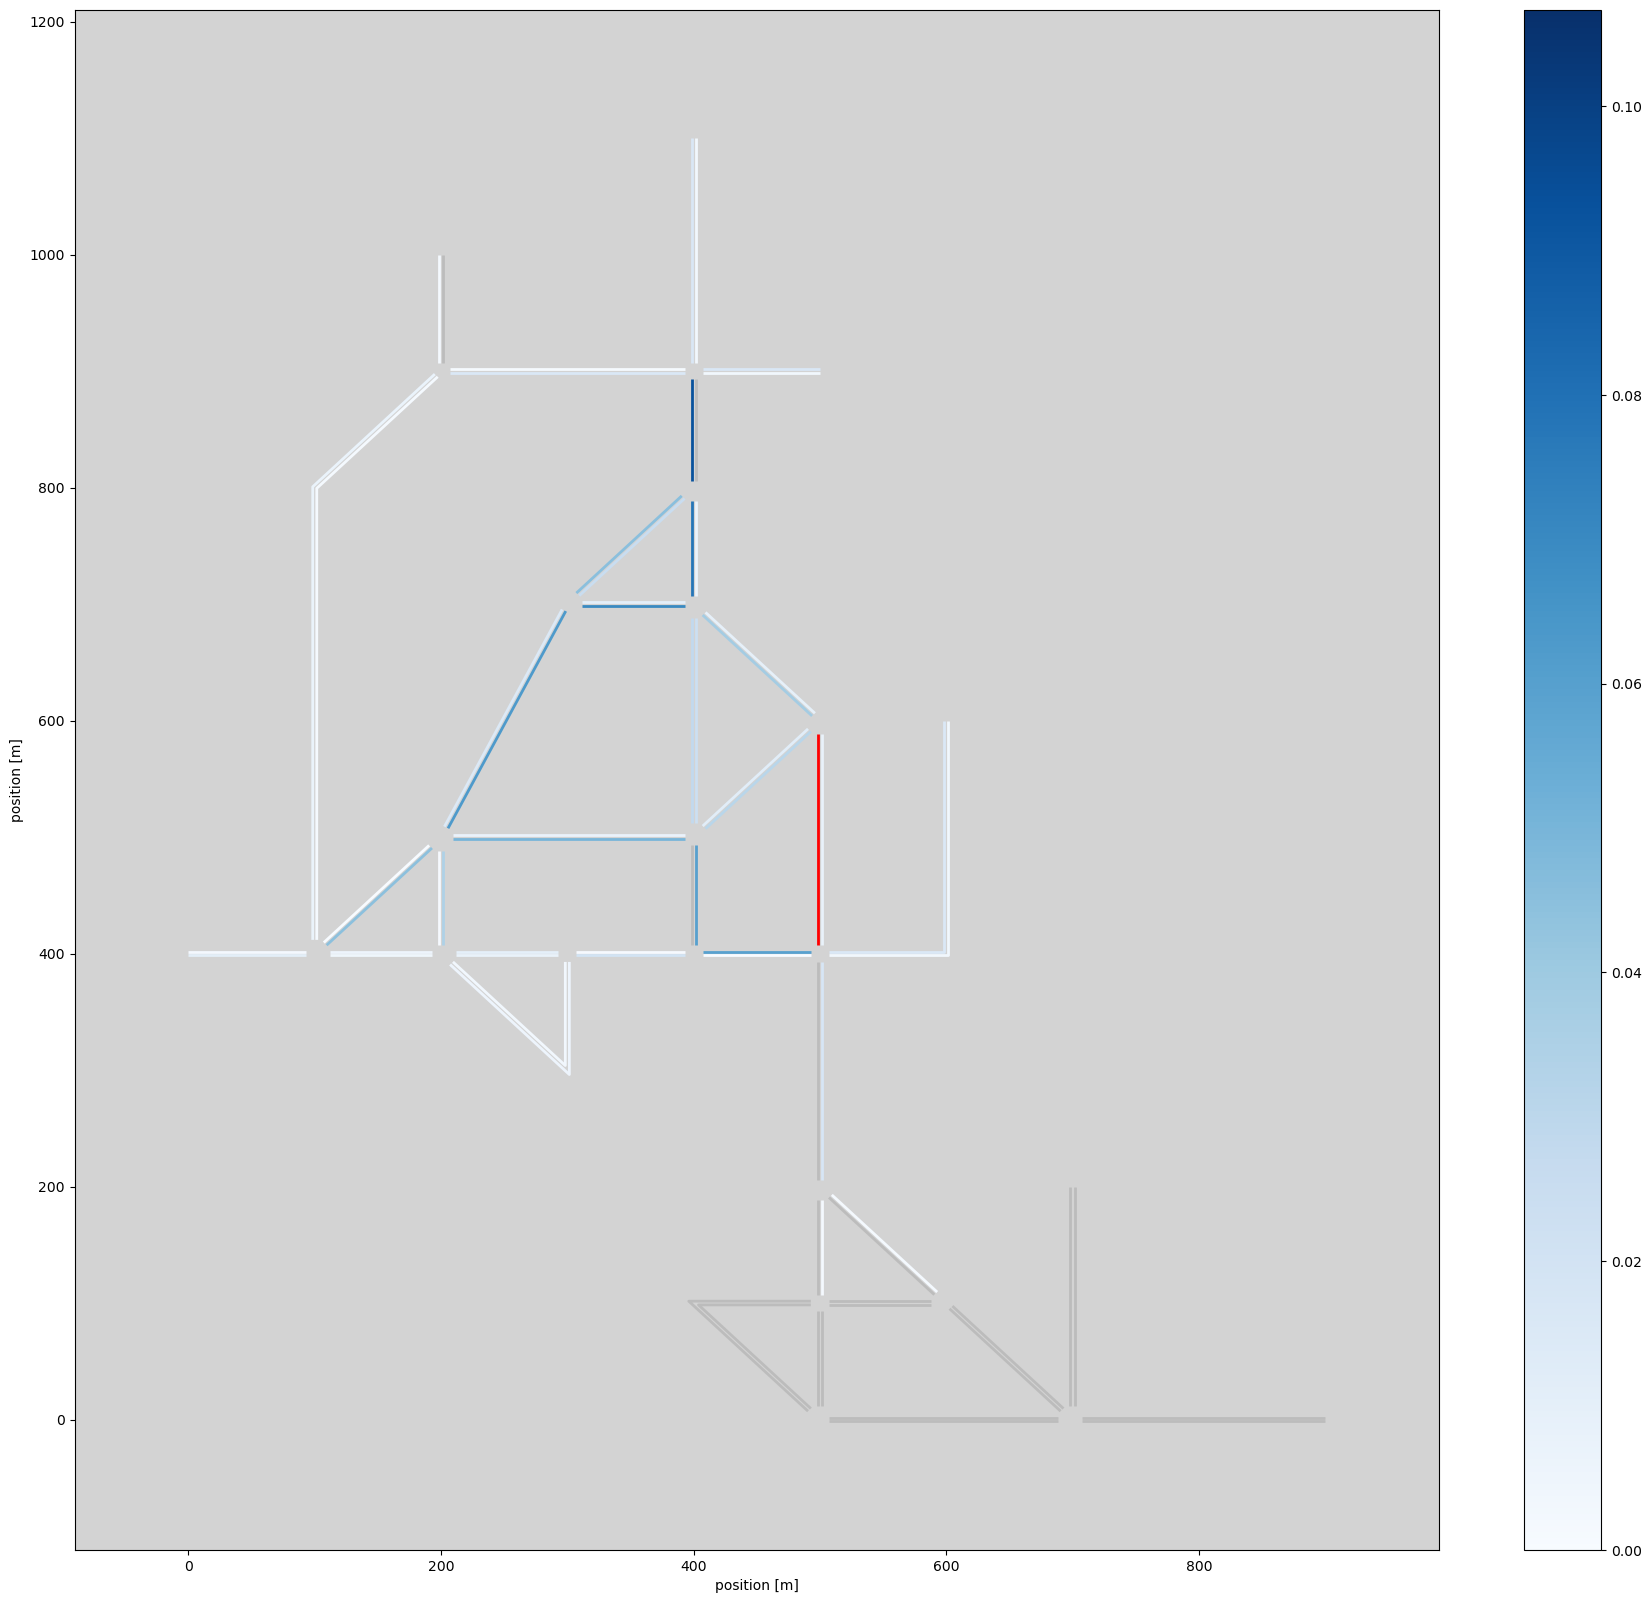

In [70]:
from importlib import reload
import visualization

reload(visualization)

visualization.plot_network_probs("../../01_simulation/02_scenario/rand_grid.net.xml", probabilities=source_probs[18], index_to_edge_map=idx_to_edge,
                                 special_edges=["18"], cmap="Blues")

## Calculating forward probabilities

In [26]:
STEP_LENGTH = 4

In [27]:
with open(EDGE_MAP_PATH) as f:
    edge_maps = json.load(f)
idx_to_edge = edge_maps["idx_to_edge"]
edge_to_idx = edge_maps["edge_to_idx"]

In [28]:
movements = np.loadtxt(MOV_PROB_PATH, delimiter=",")
for i in range(len(movements)):
    movements[i] = movements[i]/np.sum(movements[i])

In [29]:
forward_probs = {}
for i in range(len(movements)):
    prob = movements[i]
    for j in range(STEP_LENGTH):
        prob = prob + prob @ movements
    prob = prob/np.sum(prob)
    forward_probs[i] = prob.tolist()

In [30]:
with open(FORWARD_PROB_PATH, "w") as f:
    json.dump(forward_probs, f)

(<Figure size 2200x2000 with 2 Axes>,
 <Axes: xlabel='position [m]', ylabel='position [m]'>)

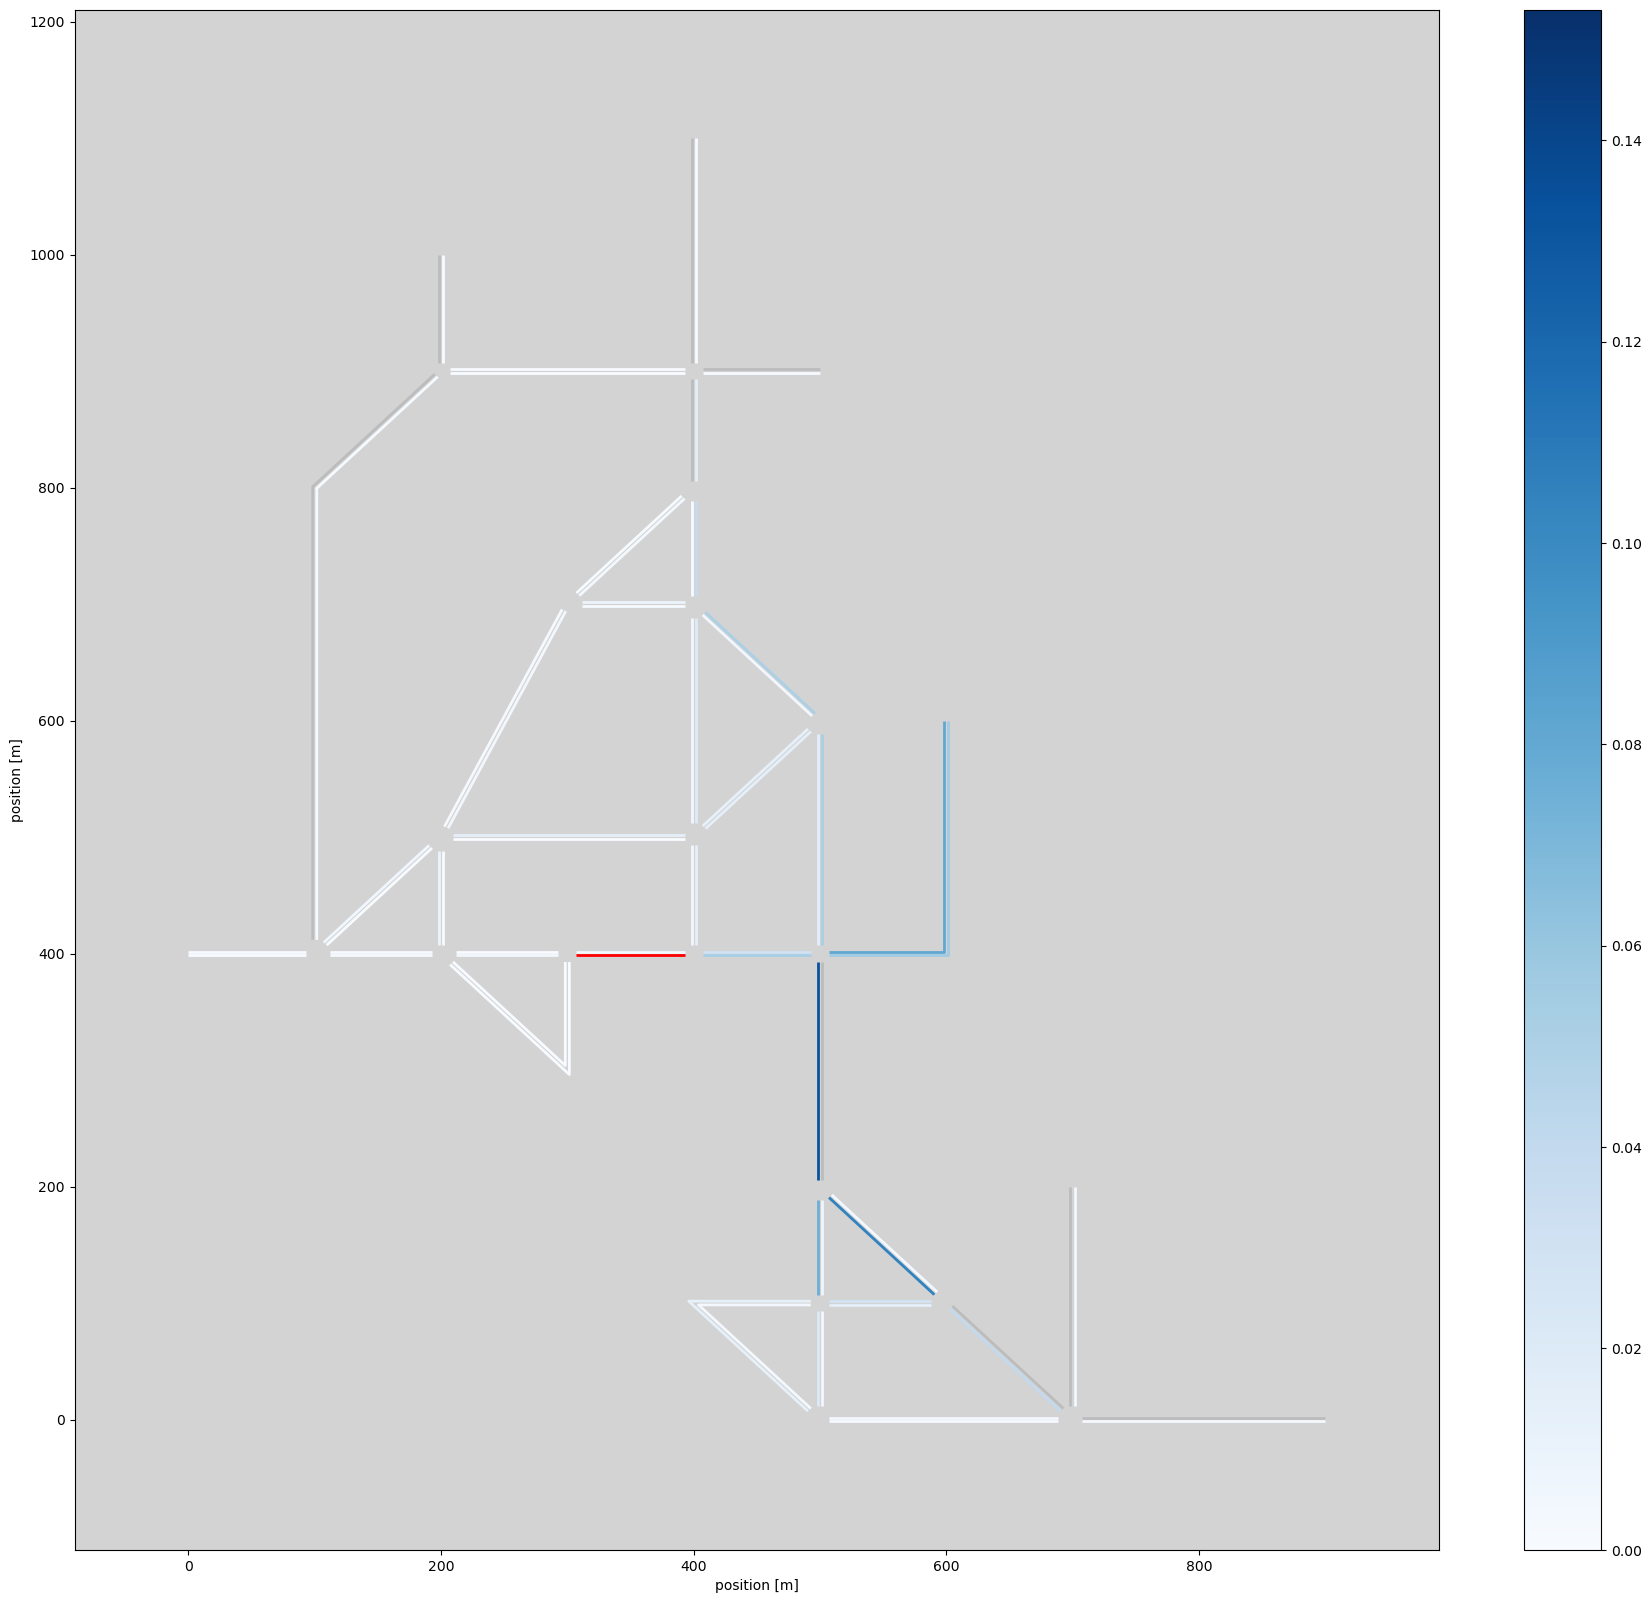

In [31]:
from importlib import reload
import visualization

reload(visualization)

visualization.plot_network_probs("../../01_simulation/02_scenario/rand_grid.net.xml", probabilities=forward_probs[40], index_to_edge_map=idx_to_edge,
                                 special_edges=["40"], cmap="Blues")

## Calculating backward per step probabilities

In [4]:
with open(EDGE_MAP_PATH) as f:
    edge_maps = json.load(f)
idx_to_edge = edge_maps["idx_to_edge"]
edge_to_idx = edge_maps["edge_to_idx"]

In [5]:
mov_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = f'{RESULTS_ROOT}/vehicle_positions_{s}.csv'
    md = pd.read_csv(filename)
    md = md[~md["edge"].str.contains(r"^:.*")]
    md["seed"] = [s]*len(md)
    mov_data = pd.concat([mov_data, md])

mov_data = mov_data["veh_id"].apply(combine_commuters)

In [6]:
#movements[i,j]: probability that a car moves from edge i to edge j
#inverse[i,j]: probability that a car on edge i came from edge j
movements = np.loadtxt(MOV_PROB_PATH, delimiter=",")
inverse = np.zeros_like(movements)
for i in range(len(movements)):
    movements[i] = movements[i]/np.sum(movements[i])
    inverse[:,i] = movements[i]

for i in range(len(inverse)):
    inverse[i] = inverse[i]/np.sum(inverse[i])

In [11]:
MAX_LENGTH = 20

backward_probs_per_steps = []
for edge in range(len(inverse)):
    prob_array = []
    for depth in range(MAX_LENGTH):
        prob = inverse[edge]
        for j in range(depth):
            prob = prob @ inverse
            prob_array.append(prob)
    backward_probs_per_steps.append(prob_array)

In [12]:
with open(BACKWARD_PROB_PER_STEP_PATH, "wb") as f:
    pickle.dump(backward_probs_per_steps, f)

## Create test data for FL location inference

In [2]:
with open(ONE_HOT_ENCODING_PATH) as f:
    oh_encoding_dict = json.load(f)

In [3]:
test_data = {}
for p in oh_encoding_dict:
    test_data_p = np.zeros((24*60*60, len(oh_encoding_dict)+1)).astype(np.float32)
    i = oh_encoding_dict[p]
    for j in range(24*60*60):
        test_data_p[j, i] = 1 # setting the one hot encoding
        test_data_p[j, -1] = j/(24*60*60) # setting the time of day
    test_data[p] = test_data_p

In [4]:
with open(FL_TEST_DATA_PATH, "wb") as f:
    pickle.dump(test_data, f)

In [6]:
x = np.zeros((4,4))
x[:,2] = 1.0
x[:,-1] = np.linspace(0, 1, len(x))
x

array([[0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        , 0.33333333],
       [0.        , 0.        , 1.        , 0.66666667],
       [0.        , 0.        , 1.        , 1.        ]])